# Shapeland: solving the problem of wait times with a pushdown automaton

Shapeland (based on Disneyland) is a fairly popular amusement park. Its main problem is the wait time of their attractions. There have been some strategies for optimizing queues, such a virtual lines and reservation systems. Nevertheless, this only solved the problem for the minority of people who knew how to take advantage of this system. For those who did not, the problem became worse.

The authors of this notebook propose a system using a pushdown automaton. This will ensure that a system of virtual lines will not affect the stand-by lines in order to improve the experience for the mayority of users.

In order to measure the success of our system, we will run two simulations. LLENAR CON MÁS INFORMACIÓN

## Creating the database

The code for this section will create the database of the simulation. The focus of the database will be on: the types of visitors and the characteristics of the attractions. 

In [113]:
import pandas as pd
import random
import matplotlib.pyplot as plt

### Types of visitors


There are 7 types of visitors:
-	**Ride enthusiasts**
People that only visit the park for the games, which is why it’s more probable that they have fastpasses and be willing to wait as much as it is necessary to go on a ride, being one of the visitors with the most time inside the park. They would rather skip activities if it were necessary.
-	**Ride fanatics**
Like enthusiasts, these visitors have a preference towards rides and games, but they’re more flexible towards joining an activity, having a higher probability in comparison to enthusiasts, but still being lower to their probability of going on a ride. They also stay shorter at the park. They’re a “tamer” version of the enthusiasts.
-	**Average tourists**
Just as their name says, they’re the most common type of visitors, having no preference whatsoever to any kind of attraction. Their time inside the park is quite short, just like their patience, and there’s a 50% probability that they would have a fastpass.
-	**Activities fanatics**
Unlike the ride’s fanatic, they prefer other types of entertainment. Because of this, they’re used to shorter wait times, making them unlikely to have a fastpass.
-	**Annual passholders**
Park fanatics, so much so that they visit it at least once a year. They have barely any patience since they want to enjoy the park to the fullest, both with games and activities equally, staying in the park for a considerable amount of time.
-	**Entitled annual passholders**
The main difference beetwen this annual passholder and the normal one is their (even more) reduced patience, believing that having an annual pass makes them better than other visitors, and that they’re entitled to a better experience. They’re one of the visitors that stay the longer at the park.
-	**Vloggers**
They only visit the park to have content for their social media, staying inside the park for only a few hours, being very impatient too, not really caring how they’ll use their time as long as the wait time is short.


In [114]:
Attraction_Enthusiast = {
    'Type': "Attraction Enthusiast",
    'Park Time Preference': 540,
    'Attraction Wait Time': 240,
    'Game Preference': 0.9,
    'Activity Preference': 0.1,
    'FastPass Probability': 0.9,
    'Percentage': 0.15
}

Attraction_Fanatic = {
    'Type': "Attraction Fanatic",
    'Park Time Preference': 480,
    'Attraction Wait Time': 180,
    'Game Preference': 0.7,
    'Activity Preference': 0.3,
    'FastPass Probability': 0.7,
    'Percentage': 0.2  
}

Average_Tourist = {
    'Type': "Average Tourist",
    'Park Time Preference': 420,
    'Attraction Wait Time': 120,
    'Game Preference': 0.6,
    'Activity Preference': 0.4,
    'FastPass Probability': 0.5,
    'Percentage': 0.25
}

Activities_Fanatic = {
    'Type': "Activities Fanatic",
    'Park Time Preference': 480,
    'Attraction Wait Time': 60,
    'Game Preference': 0.3,
    'Activity Preference': 0.7,
    'FastPass Probability': 0.3,
    'Percentage': 0.12
}

Annual_Passholder = {
    'Type': "Annual Passholder",
    'Park Time Preference': 480,
    'Attraction Wait Time': 30,
    'Game Preference': 0.4,
    'Activity Preference': 0.6,
    'FastPass Probability': 0.5,
    'Percentage': 0.1
}

Entitled_Annual_Passholder = {
    'Type': "Entitled Annual Passholder",
    'Park Time Preference': 540,
    'Attraction Wait Time': 20,
    'Game Preference': 0.3,
    'Activity Preference': 0.7,
    'FastPass Probability': 0.3,
    'Percentage': 0.08
}

Vlogger = {
    'Type': "Vlogger",
    'Park Time Preference': 360,
    'Attraction Wait Time': 10,
    'Game Preference': 0.5,
    'Activity Preference': 0.5,
    'FastPass Probability': 0.2,
    'Percentage': 0.1
}

def append_row(df, row):
    return pd.concat([df,
                    pd.DataFrame([row], columns=row.index)]
                    ).reset_index(drop=True)

list_rows = [Attraction_Fanatic, Average_Tourist, Activities_Fanatic,
             Annual_Passholder, Entitled_Annual_Passholder, Vlogger]


visitors = pd.DataFrame.from_dict([Attraction_Enthusiast])
for row in list_rows:
    new_row = pd.Series(row)
    visitors = append_row(visitors, new_row)
visitors

,Type,Park Time Preference,Attraction Wait Time,Game Preference,Activity Preference,FastPass Probability,Percentage
0,Attraction Enthusiast,540,240,0.9,0.1,0.9,0.15
1,Attraction Fanatic,480,180,0.7,0.3,0.7,0.20
2,Average Tourist,420,120,0.6,0.4,0.5,0.25
3,Activities Fanatic,480,60,0.3,0.7,0.3,0.12
4,Annual Passholder,480,30,0.4,0.6,0.5,0.10
5,Entitled Annual Passholder,540,20,0.3,0.7,0.3,0.08
6,Vlogger,360,10,0.5,0.5,0.2,0.10


In [115]:
Avatar = {
    "Name": "Avatar Flight of Passage",
    "Type": "Game",
    "Wait Time": 120,
    "Service rate per hour": 1600,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 4800,
    "Maximum wait time for fast passes": 264,
    "Popularity" : 0.24,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Navi = {
    "Name": "Na'vi River Journey",
    "Type": "Game",
    "Wait Time": 100,
    "Service rate per hour": 1200,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 3600,
    "Maximum wait time for fast passes": 153,
    "Popularity" : 0.18,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Safari = {
    "Name": "Kilimanjaro Safaris",
    "Type": "Game",
    "Wait Time": 75,
    "Service rate per hour": 1400,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 4200,
    "Maximum wait time for fast passes": 117,
    "Popularity" : 0.15,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Disney_pals = {
    "Name": "Meet Favorite Disney Pals at Adventurers Outpost",
    "Type": "Activity",
    "Wait Time": 60,
    "Service rate per hour": 12,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.12,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Kali = {
    "Name": "Kali River Rapids",
    "Type": "Game",
    "Wait Time": 60,
    "Service rate per hour": 1800,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 5400,
    "Maximum wait time for fast passes": 90,
    "Popularity" : 0.10,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Everest = {
    "Name": "Expedition Everest - Legend of the Forbidden Mountain",
    "Type": "Game",
    "Wait Time": 50,
    "Service rate per hour": 1800,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 5400,
    "Maximum wait time for fast passes": 81,
    "Popularity" : 0.08,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Dinosaur = {
    "Name": "DINOSAUR",
    "Type": "Game",
    "Wait Time": 50,
    "Service rate per hour": 2400,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 7200,
    "Maximum wait time for fast passes": 66,
    "Popularity" : 0.07,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Primeval = {
    "Name": "Primeval Whirl",
    "Type": "Game",
    "Wait Time": 35,
    "Service rate per hour": 1000,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 3000,
    "Maximum wait time for fast passes": 66,
    "Popularity" : 0.05,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Train = {
    "Name": "Wildlife Express Train",
    "Type": "Game",
    "Wait Time": 40,
    "Service rate per hour": 1500,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 4500,
    "Maximum wait time for fast passes": 45,
    "Popularity" : 0.04,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Gorilla = {
    "Name": "Gorilla Falls Exploration Trail",
    "Type": "Activity",
    "Wait Time": 25,
    "Service rate per hour": 1000,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.05,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Bug = {
    "Name": "It's Tough to be a Bug!",
    "Type": "Game",
    "Wait Time": 25,
    "Service rate per hour": 2000,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 6000,
    "Maximum wait time for fast passes": 30,
    "Popularity" : 0.03,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Boneyard = {
    "Name": "The Boneyard",
    "Type": "Game",
    "Wait Time": 25,
    "Service rate per hour": 1000,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 3000,
    "Maximum wait time for fast passes": 30,
    "Popularity" : 0.02,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

TriceraTopTriceraTop = {
    "Name": "TriceraTop Spin",
    "Type": "Game",
    "Wait Time": 20,
    "Service rate per hour": 500,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 1500,
    "Maximum wait time for fast passes": 24,
    "Popularity" : 0.015,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

LionKing = {
    "Name": "Festival of Lion King",
    "Type": "Activity",
    "Wait Time": 90,
    "Service rate per hour": 1375,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.18,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Nemo = {
    "Name": "Finding Nemo",
    "Type": "Activity",
    "Wait Time": 75,
    "Service rate per hour": 1500,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.08,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Fossil = {
    "Name": "Fossil Fun Games",
    "Type": "Game",
    "Wait Time": 30,
    "Service rate per hour": 200,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 600,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.015,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

JungleTrek = {
    "Name": "Maharajah Jungle Trek",
    "Type": "Game",
    "Wait Time": 25,
    "Service rate per hour": 1000,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 3000,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.01,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Moana = {
    "Name": "Meet Moana",
    "Type": "Activity",
    "Wait Time": 120,
    "Service rate per hour": 12,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.15,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

TimonRafiki = {
    "Name": "Meet Timon and Rafiki",
    "Type": "Activity",
    "Wait Time": 50,
    "Service rate per hour": 12,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.07,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Tree = {
    "Name": "Tree Of Life",
    "Type": "Activity",
    "Wait Time": 90,
    "Service rate per hour": 2000,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.25,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Explorers = {
    "Name": "Wilderness Explorers",
    "Type": "Activity",
    "Wait Time": 25,
    "Service rate per hour": float('inf'),
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.03,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

StreetBand = {
    "Name": "¡Viva Gaia Street Band!",
    "Type": "Activity",
    "Wait Time": 70,
    "Service rate per hour": float('inf'),
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.03,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Affection = {
    "Name": "Affection Section",
    "Type": "Activity",
    "Wait Time": 25,
    "Service rate per hour": 200,
    "Current people in line" : 0,
    "Current wait time": 0,
    "Maximum ammount of fast passes": 0,
    "Maximum wait time for fast passes": 0,
    "Popularity" : 0.04,
    "Current amount of fast passes dispensed" : 0,
    "Current amount of people in fast pass line" : 0
}

Attraction_list = [Navi, Safari, Disney_pals, Kali, Everest, Dinosaur, Primeval, Train, Gorilla,
 Bug, Boneyard, TriceraTopTriceraTop, LionKing, Nemo, Fossil, JungleTrek, Moana, TimonRafiki,
 Tree, Explorers, StreetBand, Affection]

Attractions = pd.DataFrame.from_dict([Avatar])
for row in Attraction_list:
    new_row = pd.Series(row)
    Attractions = append_row(Attractions, new_row)
Attractions.head()

,Name,Type,Wait Time,Service rate per hour,Current people in line,Current wait time,Maximum ammount of fast passes,Maximum wait time for fast passes,Popularity,Current amount of fast passes dispensed,Current amount of people in fast pass line
0,Avatar Flight of Passage,Game,120,1600.0,0,0,4800,264,0.24,0,0
1,Na'vi River Journey,Game,100,1200.0,0,0,3600,153,0.18,0,0
2,Kilimanjaro Safaris,Game,75,1400.0,0,0,4200,117,0.15,0,0
3,Meet Favorite Disney Pals at Adventurers Outpost,Activity,60,12.0,0,0,0,0,0.12,0,0
4,Kali River Rapids,Game,60,1800.0,0,0,5400,90,0.10,0,0


## Simulating the number of visitors

Once the database about the park has been built into Data Frames, the next step is to simulate a day in the park from the types of visitors.
Shapeland will receive between 25,000 and 30,000 people daily. The park is open from 8:00 am to 7:00 pm One run from the simulation will represent one day from the simulation.

The algorithm for the simultation will do the following:
- Choose how many visitors will come that day.
- Draw the arrival time for that many people from a normal distribution with mean of 720 (12:00 pm) and standard deviation of 144.31. This means that 95% of people will arrive between 8:00 am and 6:30 pm. Those who arrive before 8:00 am will be counted as if they arrived at opening time. Those who arrive after 6:30 will be counted as if they arrived at 6:30.

In a for loop for each of the visitors it will do:

- It will roll a 7-faced weighted dice to choose the type of visitor.
- It will roll to weighted dice to choose their favorite attraction and favorite activity.
- It will fill a data frame with each row being a visitor. With the following extra attributes:
    1. Number of Fastpasses: Number of fastpasses at the moment
    2. Maximum number of Fastpasses: 2
    3. FastPass Name 1: Name of the Game or Activity
    4. FastPass Name 2: Name of the Game or Activity
    5. FastPass Return time 1: Range of returning time
    6. FastPass Return time 2: Range of returning time

In [116]:
def roll(sides, bias_list):
    """
    Function to roll a weighted dice.
    Input: the number of sides, and their weights.
    Output: the roll
    """
    assert len(bias_list) == sides
    number = random.uniform(0, sum(bias_list))
    current = 0
    for i, bias in enumerate(bias_list):
        current += bias
        if number <= current:
            return i + 1

In [117]:
##This block of code lists the weights for the dice that will be useful when creating the visitors database

columns = ["Archetype", "Park Time Preference", "Attraction Wait Time Preference", "Game Preference", 
            "Activity Preference", "FastPass", "Number of Fastpasses", "Maximum Number of Fastpasses", 
            "Favorite Attraction", "Favorite Activity", "Number of activities and games done", "Total Time waited on line"
           ]

Archetypes = ["Attraction Enthusiast", "Attraction Fanatic", "Average Tourist", "Activities Fanatic", "Annual Passholder", "Entitled Annual Passholder", "Vlogger"]

list_percentage_visitors = list(visitors["Percentage"])

list_percentage_attractions = list(Attractions[Attractions["Type"] == "Game"]["Popularity"])
list_name_attractions = list(Attractions[Attractions["Type"] == "Game"]["Name"])
list_index_attractions = list(Attractions[Attractions["Type"] == "Game"].index)

list_percentage_activities = list(Attractions[Attractions["Type"] == "Activity"]["Popularity"])
list_name_activities = list(Attractions[Attractions["Type"] == "Activity"]["Name"])
list_index_activities= list(Attractions[Attractions["Type"] == "Activity"].index)


In [118]:
visitors_simulation = pd.DataFrame(columns=columns)


for i in range(len(Archetypes)):
    roll_visitor = i
    archetype = visitors.loc[roll_visitor]["Type"]
    park_time = visitors.loc[roll_visitor]["Park Time Preference"]
    attraction_wait_time = visitors.loc[roll_visitor]["Attraction Wait Time"]
    game_preference = visitors.loc[roll_visitor]["Game Preference"]
    activity_preference = visitors.loc[roll_visitor]["Activity Preference"]
    number_of_fastpasses = 0
    maximum_fastpasses = 2
    favorite_attraction = roll(len(list_percentage_attractions), list_percentage_attractions)-1
    favorite_attraction = list_name_attractions[favorite_attraction]
    favorite_activity = roll(len(list_percentage_activities), list_percentage_activities)-1
    favorite_activity = list_name_activities[favorite_activity]
    number_of_activities_done = 0
    total_waiting_time = 0

    visitor = {
            "Archetype": archetype,
            "Park Time Preference": park_time,
            "Attraction Wait Time Preference": attraction_wait_time,
            "Game Preference": game_preference, 
            "Activity Preference": activity_preference,
            "Number of Fastpasses":number_of_fastpasses,
            "Maximum Number of Fastpasses":maximum_fastpasses,
            "Fastpass": 0,
            "FastPass name 1": "undefined",
            "FastPass name 2": "undefined",
            "FastPass returning time 1": 0,
            "FastPass returning time 2": 0,
            "Favorite Attraction": favorite_attraction,
            "Favorite Activity": favorite_activity,
            "Number of activities and games done": number_of_activities_done,
            "Total Time waited on line": total_waiting_time
    }
    new_row = pd.Series(visitor)
    visitors_simulation = append_row(visitors_simulation, new_row)
visitors_simulation

C:\Users\migue\AppData\Local\Temp\ipykernel_19932\1599537183.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df,


,Archetype,Park Time Preference,Attraction Wait Time Preference,Game Preference,Activity Preference,FastPass,Number of Fastpasses,Maximum Number of Fastpasses,Favorite Attraction,Favorite Activity,Number of activities and games done,Total Time waited on line,Fastpass,FastPass name 1,FastPass name 2,FastPass returning time 1,FastPass returning time 2
0,Attraction Enthusiast,540,240,0.9,0.1,NaN,0,2,Kilimanjaro Safaris,Meet Favorite Disney Pals at Adventurers Outpost,0,0,0.0,undefined,undefined,0.0,0.0
1,Attraction Fanatic,480,180,0.7,0.3,NaN,0,2,It's Tough to be a Bug!,¡Viva Gaia Street Band!,0,0,0.0,undefined,undefined,0.0,0.0
2,Average Tourist,420,120,0.6,0.4,NaN,0,2,Na'vi River Journey,Meet Timon and Rafiki,0,0,0.0,undefined,undefined,0.0,0.0
3,Activities Fanatic,480,60,0.3,0.7,NaN,0,2,Kali River Rapids,Festival of Lion King,0,0,0.0,undefined,undefined,0.0,0.0
4,Annual Passholder,480,30,0.4,0.6,NaN,0,2,Primeval Whirl,Finding Nemo,0,0,0.0,undefined,undefined,0.0,0.0
5,Entitled Annual Passholder,540,20,0.3,0.7,NaN,0,2,Kilimanjaro Safaris,Tree Of Life,0,0,0.0,undefined,undefined,0.0,0.0
6,Vlogger,360,10,0.5,0.5,NaN,0,2,Na'vi River Journey,Tree Of Life,0,0,0.0,undefined,undefined,0.0,0.0


## Simulation 1: No Automaton Implementation

Now, we will create copies of the databases from Attractions and Visitors, to manipulate them

In [119]:
Attractions_No_Fastpass = Attractions.copy()
Attractions_Fastpass = Attractions.copy()
visitors_No_Fastpass = visitors_simulation.copy()
visitors_Fastpass = visitors_simulation.copy()

The simulation will go person by person

In [120]:
for i in range(7):
    visitor = list(visitors_No_Fastpass.loc[i])
    maximum_stay = int(visitor[1])
    time_on_park = visitor[11]
    activities = 0
    while time_on_park <= maximum_stay:
        weight_game = visitors_No_Fastpass.loc[i,'Game Preference']
        weight_activity = visitors_No_Fastpass.loc[i,'Activity Preference']
        choosing_game_activity = roll(2, [weight_game, weight_activity])
        if choosing_game_activity == 1:
            ride = roll(13, list_percentage_attractions)-1
            ride = list_name_attractions[ride]
        if choosing_game_activity == 2:
            ride = roll(10, list_percentage_activities)-1
            ride = list_name_activities[ride]
        wait_time = Attractions_No_Fastpass[Attractions_No_Fastpass['Name'] == ride]['Wait Time']
        wait_time = wait_time.iloc[0]
        time_on_park = time_on_park+wait_time
        activities += 1 
    visitors_No_Fastpass.loc[i, 'Number of activities and games done'] = activities
    visitors_No_Fastpass.loc[i, "Total Time waited on line"] = time_on_park
visitors_No_Fastpass

,Archetype,Park Time Preference,Attraction Wait Time Preference,Game Preference,Activity Preference,FastPass,Number of Fastpasses,Maximum Number of Fastpasses,Favorite Attraction,Favorite Activity,Number of activities and games done,Total Time waited on line,Fastpass,FastPass name 1,FastPass name 2,FastPass returning time 1,FastPass returning time 2
0,Attraction Enthusiast,540,240,0.9,0.1,NaN,0,2,Kilimanjaro Safaris,Meet Favorite Disney Pals at Adventurers Outpost,7,590,0.0,undefined,undefined,0.0,0.0
1,Attraction Fanatic,480,180,0.7,0.3,NaN,0,2,It's Tough to be a Bug!,¡Viva Gaia Street Band!,8,530,0.0,undefined,undefined,0.0,0.0
2,Average Tourist,420,120,0.6,0.4,NaN,0,2,Na'vi River Journey,Meet Timon and Rafiki,6,430,0.0,undefined,undefined,0.0,0.0
3,Activities Fanatic,480,60,0.3,0.7,NaN,0,2,Kali River Rapids,Festival of Lion King,6,515,0.0,undefined,undefined,0.0,0.0
4,Annual Passholder,480,30,0.4,0.6,NaN,0,2,Primeval Whirl,Finding Nemo,6,545,0.0,undefined,undefined,0.0,0.0
5,Entitled Annual Passholder,540,20,0.3,0.7,NaN,0,2,Kilimanjaro Safaris,Tree Of Life,6,555,0.0,undefined,undefined,0.0,0.0
6,Vlogger,360,10,0.5,0.5,NaN,0,2,Na'vi River Journey,Tree Of Life,6,480,0.0,undefined,undefined,0.0,0.0


## Pushdown Automaton Implementation

This type of automaton uses the data structure called Stack to have control of the Language the automaton acceptes. In order to create the automaton, a class callled Stack was created with the following methods:
- Push: Adds data to the top of the stack
- View_top: Shows the data at the top of the stack
- Pop: Deletes data from the top of the stack
- Is Empty: Returns True if the stack is empty

In [121]:
class Stack:
    def __init__(self) -> None:
        self.frontier = []
    
    def push(self, data):
        self.frontier.append(data)
    
    def view_top(self):
        return self.frontier[-1]
    
    def pop(self):
        self.frontier = self.frontier[:-1]
    
    def is_empty(self):
        return len(self.frontier) == 0

This pushdown automaton accepts the lenguage:


<img src='automaton.jpeg' width="758" height="411">

<img src='Formal.jpeg' width="758" height="411">

In [122]:
def change_status(status, string, stack:Stack):
    if status == 7:
        return 1
    if status == 0:
        status = 1
        stack.push("#")
        return change_status(status, string, stack)
    if status == 1:
        if string[0] == "i" and stack.view_top() == '#':
            string = string[1:]
            status = 2
            stack.push("I")
            return change_status(status, string, stack)
    if status == 2:
        if string[0] == 'i' and stack.view_top() == "I":
            string = string[1:]
            status = 3
            stack.push("I")
            return change_status(status, string, stack)
    if status == 3:
        if string[0] == 'i' and stack.view_top() == "I":
            string = string[1:]
            status = 2
            stack.push("I")
            return change_status(status, string, stack)
        if string[0] == "j" and stack.view_top() == "I":
            string = string[1:]
            status = 4
            stack.push("J")
            return change_status(status, string, stack)
    if status == 4:
        if string[0] == 'j' and stack.view_top() == 'J':
            string = string[1:]
            status = 5
            stack.push("J")
            return change_status(status, string, stack)
    if status == 5:
        if string[0] == 'j' and stack.view_top() == 'J':
            string = string[1:]
            status = 4
            stack.push("J")
            return change_status(status, string, stack)    
        if string[0] == 'k' and stack.view_top() == 'J':
            string = string[1:]
            status = 6
            stack.pop()
            return change_status(status, string, stack)
    if status == 6:
        if string[0] == 'k' and (stack.view_top() == 'J' or stack.view_top() == 'I'):
            string = string[1:]
            status = 6
            stack.pop()
            return change_status(status, string, stack)
        if string[0] == 'l' and stack.view_top() == "#":
            status = 7
            stack.pop()
            return change_status(status, string, stack)
    else: return 0
    

def automaton(string):
    stack = Stack()
    status = 0
    return change_status(status, string, stack)

The string will be made from the following conditions:
- The next function adds two i's if the person doesn't have fastpass, but tries to get in the virtual queue.
- The fuction adds one i if the person has fastpass.
- If person has 0 fastpasses, the fuction adds 3 i's.
- If the person has 1 fastpass, the fuction adds 1 i's
- If the person has 2 fastpasses, the fuction adds 0 i's

- If the game of activity has a wait time of between 0 and the maximum wait time, the fuction adds a few pair of j's, depending the waiting.
- If the wait time is more than the maximum, then it adds 7 j's in order to not dispense a fastpass.

- If the maximum number of fastpasses dispensed has not been reached, then the fuction adds equal ammount of k's as the sum of i's plus j's. If it has been reached, then it adds nothing.

In [123]:
visitors_Fastpass = visitors_Fastpass.assign(FastPass = 1).copy()

def get_string(index_person, activity_or_ride, name_ride):
    fastpass = visitors_Fastpass.loc[index_person, "FastPass"]
    string = ""
    if fastpass == 1:
        string = string+"i"
    if fastpass == 0:
        string = string+"ii"
    
    fastpass1 = visitors_Fastpass.loc[index_person, 'FastPass name 1']
    fastpass2 = visitors_Fastpass.loc[index_person, 'FastPass name 2']
    if fastpass1 == 'undefined' and fastpass2 == 'undefined':
        string = string+'iii'
    if (fastpass1 == 'undefined' and not fastpass2 == 'undefined') or (fastpass2 == 'undefined' and not fastpass1 == 'undefined'):
        string = string+'i'
    if not fastpass1 == 'undefined' and not fastpass2 == 'undefined':
        string = string+''
    
    if activity_or_ride == 2:
        for i in range(len(list_name_activities)):
            if list_name_activities[i] == name_ride:
                index = i
                break
        index_df = list_index_activities[index]
    if activity_or_ride == 1:
        for i in range(len(list_name_attractions)):
            if list_name_attractions[i] == name_ride:
                index = i
                break
        index_df = list_index_attractions[index]
    maximum_wait_time = Attractions_Fastpass.loc[index_df, "Maximum wait time for fast passes"]
    current_time = 3
    if maximum_wait_time != 0:
        wait_time = Attractions_Fastpass.loc[index_df, "Wait Time"]
        current_time = maximum_wait_time - wait_time
        current_time = int(current_time/60)
    if current_time == 0:
        string = string+'jj'
    if current_time == 1:
        string = string+'jjjj'
    if current_time == 2:
        string = string+'jjjjjj'
    if current_time == 3:
        string = string+'j'
    
    for i in range(len(string)):
        string = string+'k'
    string = string+'l'

    return string

print(automaton(get_string(1, 2, "Meet Moana")))


0


In [124]:
for i in range(7):
    visitor = list(visitors_Fastpass.loc[i])
    maximum_stay = int(visitor[1])
    time_on_park = visitor[11]
    activities = 0
    while time_on_park <= maximum_stay:
        weight_game = visitors_Fastpass.loc[i,'Game Preference']
        weight_activity = visitors_Fastpass.loc[i,'Activity Preference']
        choosing_game_activity = roll(2, [weight_game, weight_activity])
        if choosing_game_activity == 1:
            ride = roll(13, list_percentage_attractions)-1
            ride = list_name_attractions[ride]
        if choosing_game_activity == 2:
            ride = roll(10, list_percentage_activities)-1
            ride = list_name_activities[ride]
            
        string = get_string(i, choosing_game_activity, ride)
        verified = automaton(string)
        if verified == 1:
            if (visitors_Fastpass.loc[i, 'FastPass name 1'] == 'undefined') and (visitors_Fastpass.loc[i, 'FastPass name 2'] != 'undefined'):
                visitors_Fastpass.loc[i, "FastPass returning time 1"] = visitors_Fastpass.loc[i, "FastPass returning time 2"]
                visitors_Fastpass.loc[i, 'FastPass name 1'] = visitors_Fastpass.loc[i, 'FastPass name 2']
                visitors_Fastpass.loc[i, "FastPass returning time 2"] = 0
                visitors_Fastpass.loc[i, 'FastPass name 2'] = 'undefined'  
            if visitors_Fastpass.loc[i, 'FastPass name 1'] == 'undefined' and visitors_Fastpass.loc[i, 'FastPass name 1'] == 'undefined':
                visitors_Fastpass.loc[i, 'FastPass name 1'] = ride
                return_time = Attractions_Fastpass[Attractions_Fastpass['Name'] == ride]['Wait Time']
                return_time = return_time.iloc[0] * 1.5
                visitors_Fastpass.loc[i, "FastPass returning time 1"] = return_time
                continue
            if visitors_Fastpass.loc[i, 'FastPass name 1'] != 'undefined' and visitors_Fastpass.loc[i, 'FastPass name 2'] == 'undefined':
                visitors_Fastpass.loc[i, 'FastPass name 2'] = ride
                return_time = visitors_Fastpass.loc[i, "FastPass returning time 1"]
                return_time = return_time + 20
                visitors_Fastpass.loc[i, "FastPass returning time 2"] = return_time
                continue          
        if (visitors_Fastpass.loc[i, 'FastPass name 1'] == 'undefined') and (visitors_Fastpass.loc[i, 'FastPass name 2'] == 'undefined'):
            wait_time = Attractions_No_Fastpass[Attractions_Fastpass['Name'] == ride]['Wait Time']
            wait_time = wait_time.iloc[0]
            time_on_park = time_on_park+wait_time
            activities += 1 
            continue
        if (visitors_Fastpass.loc[i, 'FastPass name 1'] != 'undefined') and (visitors_Fastpass.loc[i, 'FastPass name 2'] == 'undefined'):
            wait_time = Attractions_No_Fastpass[Attractions_Fastpass['Name'] == ride]['Wait Time']
            wait_time = wait_time.iloc[0]
            return_time = visitors_Fastpass.loc[i, "FastPass returning time 1"]
            if wait_time <= return_time:
                time_on_park = time_on_park + wait_time
                return_time = return_time - wait_time
                visitors_Fastpass.loc[i, "FastPass returning time 1"] = return_time
                continue
            if return_time <= wait_time:
                time_on_park = time_on_park + return_time
                activities += 1
                visitors_Fastpass.loc[i, "FastPass returning time 1"] = 0
                visitors_Fastpass.loc[i, 'FastPass name 1'] = 'undefined'
                continue
        if (visitors_Fastpass.loc[i, 'FastPass name 1'] == 'undefined') and (visitors_Fastpass.loc[i, 'FastPass name 2'] != 'undefined'):
            visitors_Fastpass.loc[i, "FastPass returning time 1"] = visitors_Fastpass.loc[i, "FastPass returning time 2"]
            visitors_Fastpass.loc[i, 'FastPass name 1'] = visitors_Fastpass.loc[i, 'FastPass name 2']
            visitors_Fastpass.loc[i, "FastPass returning time 2"] = 0
            visitors_Fastpass.loc[i, 'FastPass name 2'] = 'undefined'
            continue
        if (visitors_Fastpass.loc[i, 'FastPass name 1'] != 'undefined') and (visitors_Fastpass.loc[i, 'FastPass name 2'] != 'undefined'):
            wait_time = Attractions_No_Fastpass[Attractions_Fastpass['Name'] == ride]['Wait Time']
            wait_time = wait_time.iloc[0]
            return_time = visitors_Fastpass.loc[i, "FastPass returning time 1"]
            return_time2 = visitors_Fastpass.loc[i, "FastPass returning time 2"]
            if wait_time <= return_time:
                time_on_park = time_on_park + wait_time
                return_time = return_time - wait_time
                return_time2 = return_time2 - wait_time
                visitors_Fastpass.loc[i, "FastPass returning time 1"] = return_time
                visitors_Fastpass.loc[i, "FastPass returning time 2"] = return_time2
                continue
            if return_time <= wait_time:
                time_on_park = time_on_park + return_time
                activities += 1
                visitors_Fastpass.loc[i, "FastPass returning time 1"] = 0
                visitors_Fastpass.loc[i, 'FastPass name 1'] = 'undefined'
                return_time2 = return_time2 - return_time
                visitors_Fastpass.loc[i, "FastPass returning time 2"] = return_time2               
                continue
    visitors_Fastpass.loc[i, 'Number of activities and games done'] = activities
    visitors_Fastpass.loc[i, "Total Time waited on line"] = time_on_park
visitors_Fastpass


,Archetype,Park Time Preference,Attraction Wait Time Preference,Game Preference,Activity Preference,FastPass,Number of Fastpasses,Maximum Number of Fastpasses,Favorite Attraction,Favorite Activity,Number of activities and games done,Total Time waited on line,Fastpass,FastPass name 1,FastPass name 2,FastPass returning time 1,FastPass returning time 2
0,Attraction Enthusiast,540,240,0.9,0.1,1,0,2,Kilimanjaro Safaris,Meet Favorite Disney Pals at Adventurers Outpost,20,560.0,0.0,undefined,Avatar Flight of Passage,0.0,20.0
1,Attraction Fanatic,480,180,0.7,0.3,1,0,2,It's Tough to be a Bug!,¡Viva Gaia Street Band!,9,525.0,0.0,undefined,undefined,0.0,0.0
2,Average Tourist,420,120,0.6,0.4,1,0,2,Na'vi River Journey,Meet Timon and Rafiki,13,435.0,0.0,Na'vi River Journey,Kilimanjaro Safaris,90.0,110.0
3,Activities Fanatic,480,60,0.3,0.7,1,0,2,Kali River Rapids,Festival of Lion King,5,500.0,0.0,Avatar Flight of Passage,undefined,120.0,0.0
4,Annual Passholder,480,30,0.4,0.6,1,0,2,Primeval Whirl,Finding Nemo,7,490.0,0.0,Avatar Flight of Passage,undefined,90.0,0.0
5,Entitled Annual Passholder,540,20,0.3,0.7,1,0,2,Kilimanjaro Safaris,Tree Of Life,7,620.0,0.0,undefined,undefined,0.0,0.0
6,Vlogger,360,10,0.5,0.5,1,0,2,Na'vi River Journey,Tree Of Life,6,417.5,0.0,undefined,undefined,0.0,0.0


## Graphs

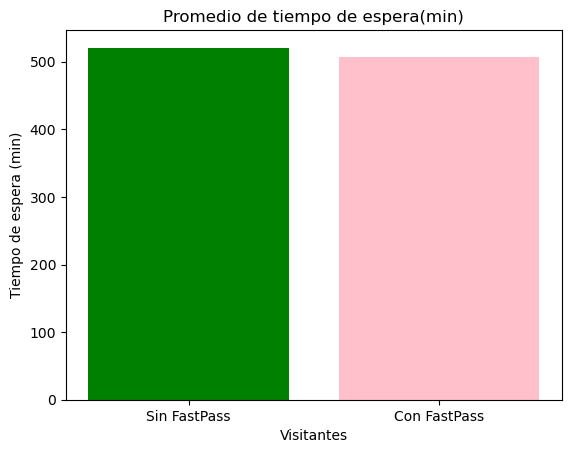

In [125]:
average_timeNofastpass = visitors_No_Fastpass["Total Time waited on line"].mean()
average_timefastpass = visitors_Fastpass["Total Time waited on line"].mean()

visitantes = ['Sin FastPass', 'Con FastPass']
promedio_tiempo_de_espera = [average_timeNofastpass, average_timefastpass]

plt.bar(visitantes, promedio_tiempo_de_espera, color=['green', 'pink'])

plt.title('Promedio de tiempo de espera(min)')
plt.ylabel('Tiempo de espera (min)')
plt.xlabel('Visitantes')

plt.show()


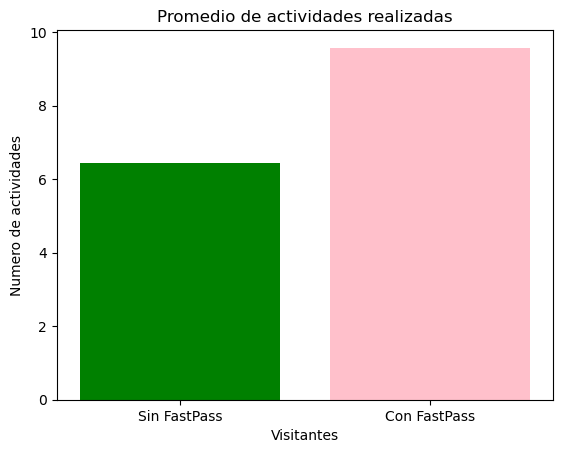

In [126]:
average_timeNofastpass = visitors_No_Fastpass["Number of activities and games done"].mean()
average_timefastpass = visitors_Fastpass["Number of activities and games done"].mean()

visitantes = ['Sin FastPass', 'Con FastPass']
promedio_tiempo_de_espera = [average_timeNofastpass, average_timefastpass]

plt.bar(visitantes, promedio_tiempo_de_espera, color=['green', 'pink'])

plt.title('Promedio de actividades realizadas')
plt.ylabel('Numero de actividades')
plt.xlabel('Visitantes')

plt.show()